### Exploratory Data Analysis (EDA)

### 🔹 1. Univariate Analysis
This is about understanding each feature individually.

🔸 a) Target variable: class (Fraud vs. Not Fraud)

In [1]:
# Load datasets
import pandas as pd
fraud_df = pd.read_csv('../data/processed/fraud_cleaned.csv')
credit_df = pd.read_csv('../data/processed/credit_cleaned.csv')
ip_df = pd.read_csv('../data/processed/ip_cleaned.csv')    

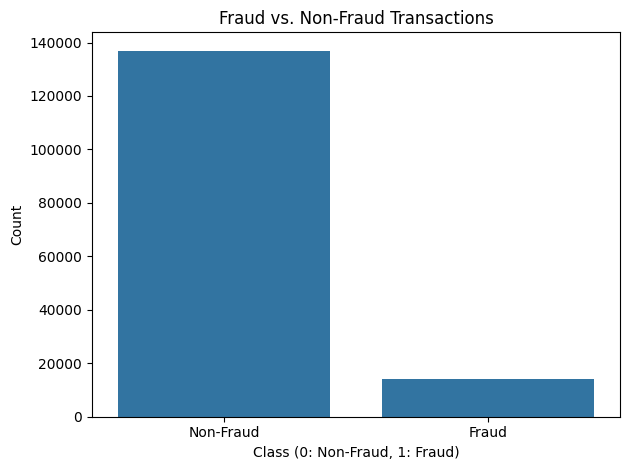

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud vs. Non-Fraud Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.savefig('../figures/fraud_class_distribution.png')
plt.show()

# Class imbalance ratio
fraud_ratio = fraud_df['class'].value_counts(normalize=True)
print(fraud_ratio)


🔸 b) Numerical Features

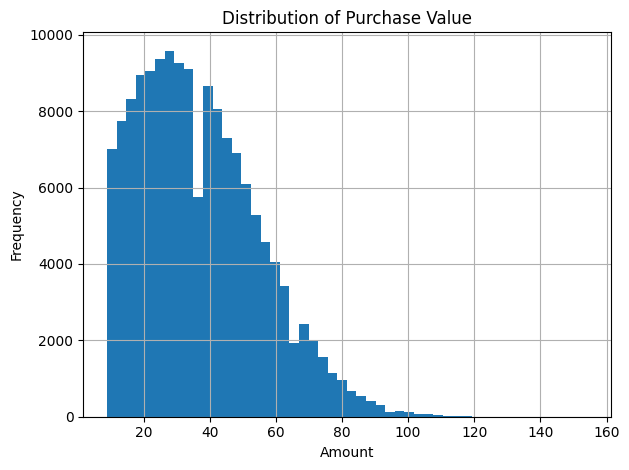

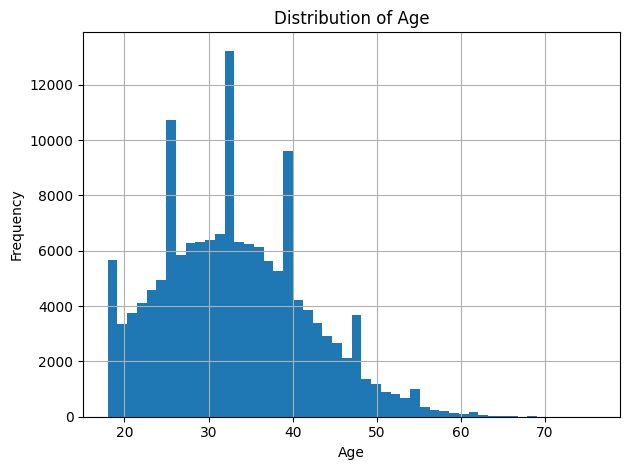

In [5]:
fraud_df[['purchase_value', 'age']].describe()

# Histograms
fraud_df['purchase_value'].hist(bins=50)
plt.title("Distribution of Purchase Value")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('../figures/purchase_value_distribution.png')
plt.show()

fraud_df['age'].hist(bins=50)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('../figures/age_distribution.png')
plt.show()


🔸 c) Categorical Features

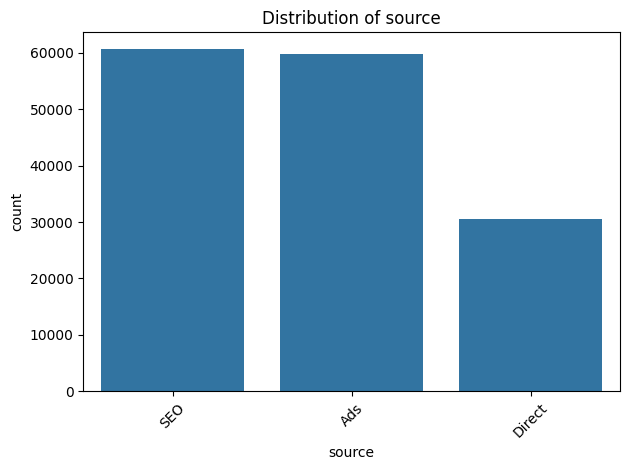

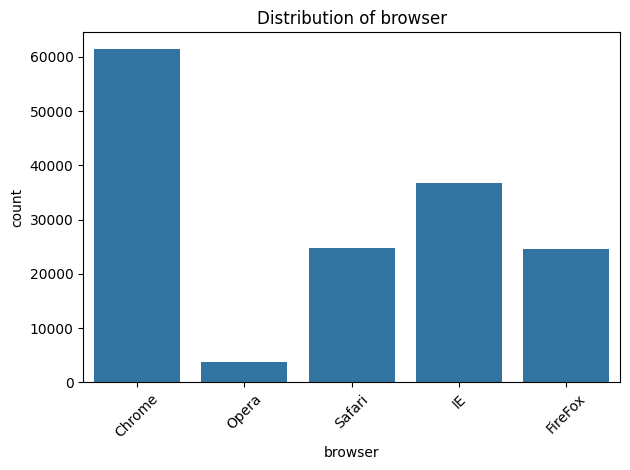

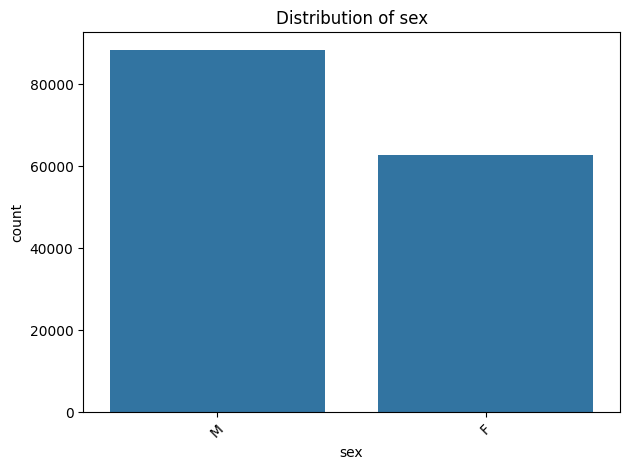

In [6]:
for col in ['source', 'browser', 'sex']:
    sns.countplot(x=col, data=fraud_df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../figures/{col}_distribution.png')
    plt.show()

### 🔹 2. Bivariate Analysis

This reveals relationships between features and the target (class).

🔸 a) Fraud by Source/Browser/Sex


Fraud rate by source:
 source
Ads       0.092066
Direct    0.105370
SEO       0.089285
Name: class, dtype: float64


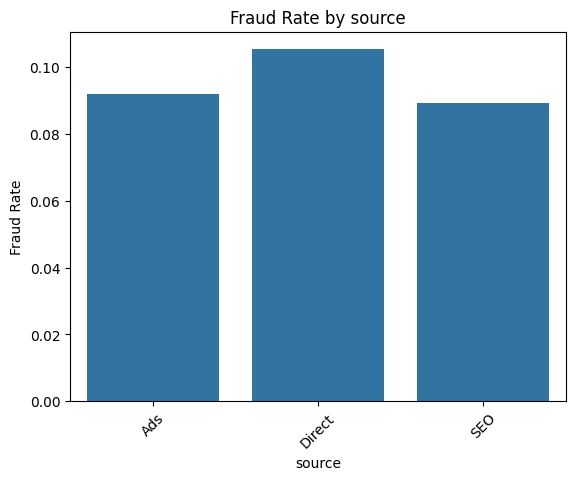


Fraud rate by browser:
 browser
Chrome     0.098792
FireFox    0.095165
IE         0.086775
Opera      0.089227
Safari     0.090201
Name: class, dtype: float64


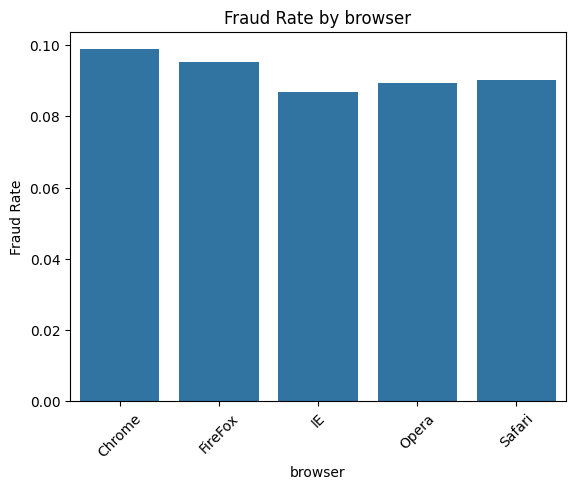


Fraud rate by sex:
 sex
F    0.091007
M    0.095523
Name: class, dtype: float64


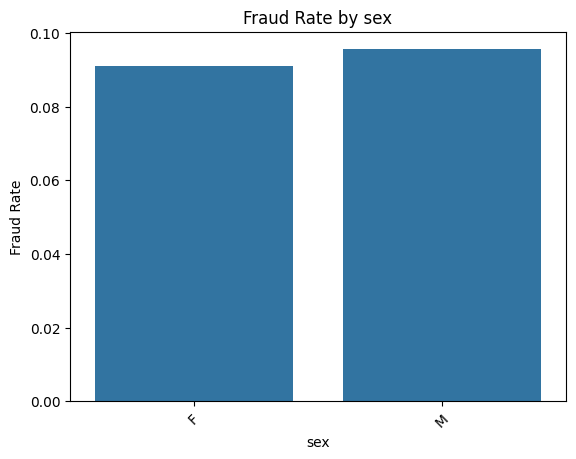

In [7]:
for col in ['source', 'browser', 'sex']:
    fraud_rate = fraud_df.groupby(col)['class'].mean()
    print(f"\nFraud rate by {col}:\n", fraud_rate)

    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel("Fraud Rate")
    plt.xticks(rotation=45)
    plt.show()

🔸 b) Purchase Value vs. Class

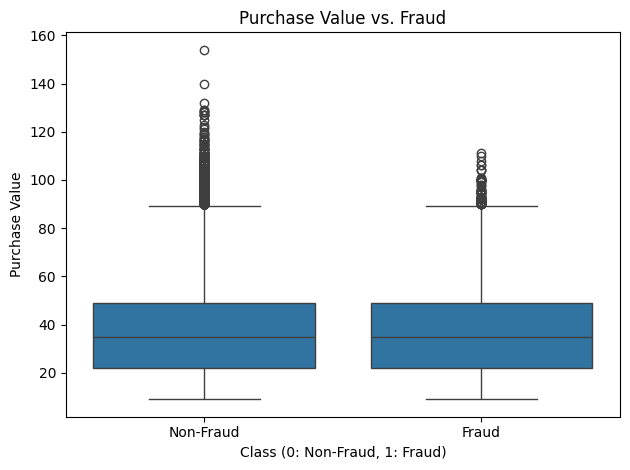

In [9]:
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value vs. Fraud')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Purchase Value')
plt.tight_layout()
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.savefig('../figures/purchase_value_vs_fraud.png')
plt.show()

🔸 c) Age vs. Fraud

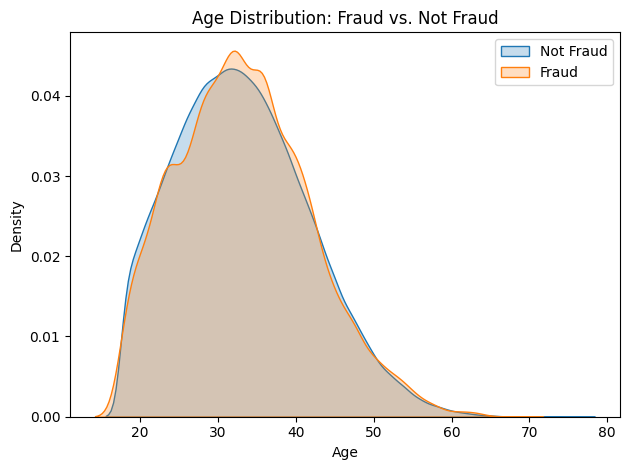

In [11]:
sns.kdeplot(data=fraud_df[fraud_df['class'] == 0], x='age', label='Not Fraud', fill=True)
sns.kdeplot(data=fraud_df[fraud_df['class'] == 1], x='age', label='Fraud', fill=True)
plt.title('Age Distribution: Fraud vs. Not Fraud')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('../figures/age_distribution_fraud_vs_not_fraud.png')
plt.legend()
plt.show()


## Merge Datasets for Geolocation Analysis

Convert IP address to integer format

In [12]:
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [13]:
fraud_df['ip_address'] = fraud_df['ip_address'].astype(float).astype(int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(float).astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(float).astype(int)

IP-to-Country Mapping Function

In [14]:
# This uses a binary search–style join for efficiency:
def map_ip_to_country(ip_series, ip_ranges):
    # Sort IP ranges for efficient lookup
    ip_ranges = ip_ranges.sort_values(by='lower_bound_ip_address').reset_index(drop=True)

    def find_country(ip):
        left, right = 0, len(ip_ranges) - 1
        while left <= right:
            mid = (left + right) // 2
            row = ip_ranges.iloc[mid]
            if row['lower_bound_ip_address'] <= ip <= row['upper_bound_ip_address']:
                return row['country']
            elif ip < row['lower_bound_ip_address']:
                right = mid - 1
            else:
                left = mid + 1
        return 'Unknown'

    return ip_series.apply(find_country)


Apply the mapping

In [15]:
fraud_df['country'] = map_ip_to_country(fraud_df['ip_address'], ip_df)

Inspect results

In [16]:
fraud_df['country'].value_counts().head()

country
United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
Name: count, dtype: int64

Save updated dataset

In [17]:
fraud_df.to_csv('../data/processed/fraud_with_country.csv', index=False)